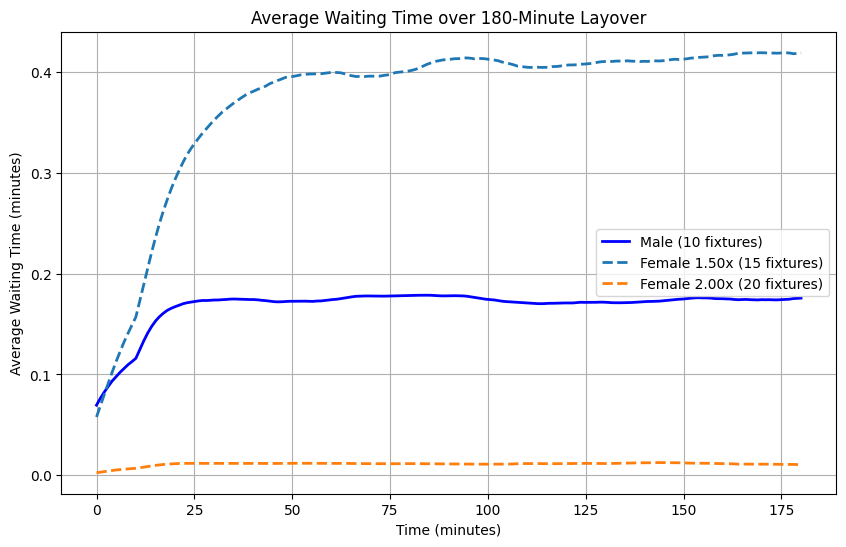

In [ ]:
# --- Female Simulation Parameters ---
arrival_rate_female = 5        # Female arrivals per minute
service_rate_female = 1/2.5      # Female service rate (per fixture)
base_fixtures_female = 10        # Base number of fixtures before scaling
fixture_scaling = {"1.50x": 1.50, "2.00x": 2.00}

def run_simulation_female(sim_time, arrival_rate, service_rate, num_fixtures):
    fixtures = [{"t_f": np.inf, "busy": False} for _ in range(num_fixtures)]
    queue = []
    s = 0.0
    wait_data = []
    t_A = np.random.exponential(1/arrival_rate)
    while s < sim_time:
        next_service_time = min(f["t_f"] for f in fixtures)
        next_event_time = min(t_A, next_service_time)
        s = next_event_time
        if t_A <= next_service_time:  # Arrival event
            if s < sim_time:
                available = next((f for f in fixtures if not f["busy"]), None)
                if available is not None:
                    available["busy"] = True
                    st = np.random.exponential(1/service_rate)
                    available["t_f"] = s + st
                    wait_data.append((s, 0.0))
                else:
                    queue.append(s)
                t_A = s + np.random.exponential(1/arrival_rate)
            else:
                t_A = np.inf
        else:  # Service completion event
            comp = next(f for f in fixtures if f["t_f"] == next_service_time)
            comp["busy"] = False
            comp["t_f"] = np.inf
            if queue:
                arr_time = queue.pop(0)
                wt = s - arr_time
                if s < sim_time:
                    wait_data.append((s, wt))
                comp["busy"] = True
                st = np.random.exponential(1/service_rate)
                comp["t_f"] = s + st
    return np.array(wait_data)

# --- Compute moving average for females ---
window_width = 20
time_grid = np.linspace(0, time_end, 180)  # same grid as for males
female_results = {}  # Dictionary to store (time_grid, moving_avg) for each scaling

for label, scale in fixture_scaling.items():
    num_fixtures_female = int(base_fixtures_female * scale)
    all_wait_data = []
    for _ in range(num_simulations):
        data = run_simulation_female(time_end, arrival_rate_female, service_rate_female, num_fixtures_female)
        all_wait_data.append(data)
    all_wait_data = np.concatenate(all_wait_data, axis=0)
    times_f = all_wait_data[:, 0]
    wait_times_f = all_wait_data[:, 1]
    moving_avg_f = []
    for t in time_grid:
        mask = (times_f >= t - window_width/2) & (times_f < t + window_width/2)
        if np.any(mask):
            moving_avg_f.append(np.mean(wait_times_f[mask]))
        else:
            moving_avg_f.append(np.nan)
    female_results[label] = (time_grid, moving_avg_f)

# --- Overlay Plot (male data already in 'time_grid' and 'moving_avg') ---
plt.figure(figsize=(10,6))
plt.plot(time_grid, moving_avg, color='blue', linewidth=2, label='Male (10 fixtures)')
for label, (tg, mov_avg) in female_results.items():
    total = int(base_fixtures_female * fixture_scaling[label])
    plt.plot(tg, mov_avg, '--', linewidth=2, label=f'Female {label} ({total} fixtures)')
plt.xlabel('Time (minutes)')
plt.ylabel('Average Waiting Time (minutes)')
plt.title('Average Waiting Time over 180-Minute Layover')
plt.legend()
plt.grid(True)
plt.show()


Total female fixtures = 16


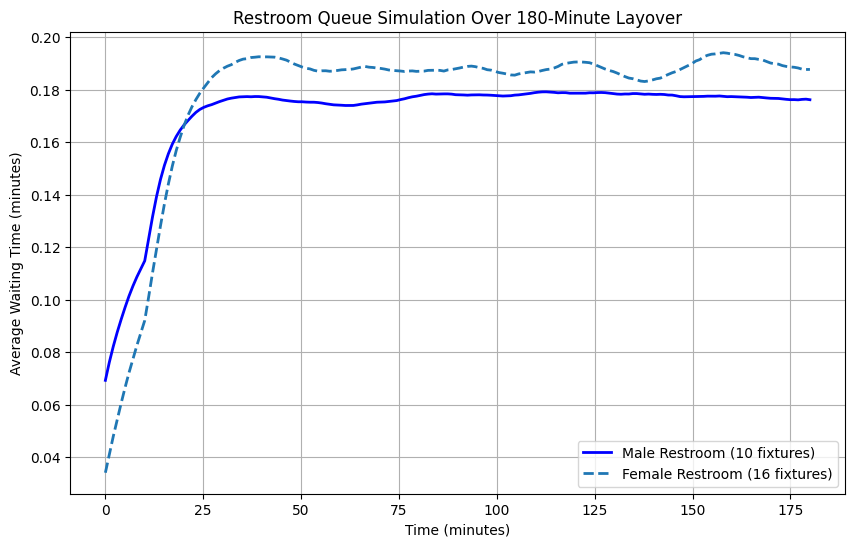

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==== Assume the male simulation has already produced these variables ====
# time_grid : a 1-D numpy array of time points (e.g., 0 to 180 minutes)
# moving_avg: the corresponding moving average waiting times for the male system
#
# (For example, they might have been computed using your previous male code.)

# ==== Female Parameters & Equitable Staffing Calculation ====
arrival_rate_female = 5          # Female arrivals per minute (same as male)
service_rate_female = 1/2.5        # Female service rate per fixture (≈0.4 per minute)

# Male parameters (for reference in the formula)
arrival_rate_male = 5            # from male simulation
service_rate_male = 0.67         # per minute
num_fixtures_male = 10

rho_male = arrival_rate_male / service_rate_male    # ≈ 5 / 0.67 ≈ 7.46
rho_female = arrival_rate_female / service_rate_female  # 5 / 0.4 = 12.5

# Equitable staffing: c_female = rho_female + (service_rate_male/service_rate_female) * (num_fixtures_male - rho_male)
total_fixtures_female = int(rho_female + (service_rate_male / service_rate_female) * (num_fixtures_male - rho_male))
print("Total female fixtures =", total_fixtures_female)  # Expected ≈ 16

# ==== Female Simulation Function (One System with a Single Queue) ====
def run_simulation(sim_time, arrival_rate, service_rate, num_fixtures):
    fixtures = [{"t_f": np.inf, "busy": False} for _ in range(num_fixtures)]
    queue = []            # Stores arrival times for waiting customers
    s = 0.0               # Simulation clock
    wait_data = []        # Will store tuples (service_start_time, waiting_time)
    
    # Schedule first arrival
    t_A = np.random.exponential(1 / arrival_rate)
    
    while s < sim_time:
        next_service_time = min(f["t_f"] for f in fixtures)
        next_event_time = min(t_A, next_service_time)
        s = next_event_time
        
        if t_A <= next_service_time:  # Arrival event
            if s < sim_time:
                available = next((f for f in fixtures if not f["busy"]), None)
                if available is not None:
                    available["busy"] = True
                    st = np.random.exponential(1 / service_rate)
                    available["t_f"] = s + st
                    wait_data.append((s, 0.0))
                else:
                    queue.append(s)
                t_A = s + np.random.exponential(1 / arrival_rate)
            else:
                t_A = np.inf
        else:  # Service completion event
            comp = next(f for f in fixtures if f["t_f"] == next_service_time)
            comp["busy"] = False
            comp["t_f"] = np.inf
            if queue:
                arr_time = queue.pop(0)
                wt = s - arr_time
                if s < sim_time:
                    wait_data.append((s, wt))
                comp["busy"] = True
                st = np.random.exponential(1 / service_rate)
                comp["t_f"] = s + st
    return np.array(wait_data)

# ==== Run Female Simulations ====
time_end = 180
num_simulations = 12000

female_all_wait_data = []
for _ in range(num_simulations):
    data = run_simulation(time_end, arrival_rate_female, service_rate_female, total_fixtures_female)
    female_all_wait_data.append(data)
female_all_wait_data = np.concatenate(female_all_wait_data, axis=0)
female_times = female_all_wait_data[:, 0]
female_wait_times = female_all_wait_data[:, 1]

# Compute moving average of waiting times for females (using a 20-minute window)
window_width = 20
female_moving_avg = []
# Use the same time_grid as for males (0 to 180 minutes, 180 points)
time_grid = np.linspace(0, time_end, 180)
for t in time_grid:
    mask = (female_times >= t - window_width/2) & (female_times < t + window_width/2)
    if np.any(mask):
        female_moving_avg.append(np.mean(female_wait_times[mask]))
    else:
        female_moving_avg.append(np.nan)

# ==== Overlay Plot: Male vs. Female ====
plt.figure(figsize=(10,6))
plt.plot(time_grid, moving_avg, color='blue', linewidth=2, label='Male Restroom (10 fixtures)')
plt.plot(time_grid, female_moving_avg, '--', linewidth=2, label=f'Female Restroom ({total_fixtures_female} fixtures)')
plt.xlabel('Time (minutes)')
plt.ylabel('Average Waiting Time (minutes)')
plt.title('Restroom Queue Simulation Over 180-Minute Layover')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import pandas as pd
file_path = "/Users/mosesnjuguna/Downloads/STATA/ComputedElements.dta"

df_main = pd.read_stata(file_path)





/var/folders/48/fhhfjkp10pzbb1jjrdykv2040000gn/T/ipykernel_32715/484409443.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_main
# Assuming your NEMSIS data is loaded in df_nemsis

filtered = df_main[
    (df_main['USCensusDivision'] == 'Middle Atlantic') &
    (df_main['Urbanicity'].isin(['Urban'])) &
    (df_main['EMSSystemResponseTimeMin'].notnull())
]


In [3]:
filtered

,PcrKey,USCensusRegion,USCensusDivision,NasemsoRegion,Urbanicity,ageinyear,EMSDispatchCenterTimeSec,EMSChuteTimeMin,EMSSystemResponseTimeMin,EMSSceneResponseTimeMin,EMSSceneTimeMin,EMSSceneToPatientTimeMin,EMSTransportTimeMin,EMSTotalCallTimeMin
48319,225907144.0,Northeast,Middle Atlantic,East,Urban,NaN,NaN,0.016667,4.200000,4.183333,NaN,NaN,NaN,7.783333
48320,225907151.0,Northeast,Middle Atlantic,East,Urban,24.0,NaN,0.016667,7.083333,7.066667,3.033333,NaN,NaN,10.133333
48321,225907154.0,Northeast,Middle Atlantic,East,Urban,NaN,NaN,0.000000,7.000000,7.000000,NaN,NaN,NaN,18.000000
48322,225907155.0,Northeast,Middle Atlantic,East,Urban,54.0,NaN,0.000000,2.650000,2.650000,16.166667,NaN,2.850000,34.216667
48323,225907220.0,Northeast,Middle Atlantic,East,Urban,58.0,65.0,0.000000,2.066667,2.066667,8.600000,NaN,3.533333,23.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54150022,289229413.0,Northeast,Middle Atlantic,East,Urban,28.0,420.0,0.000000,10.000000,10.000000,11.000000,1.000000,NaN,21.000000
54150023,289229644.0,Northeast,Middle Atlantic,East,Urban,60.0,102.0,1.550000,10.150000,8.600000,11.833333,2.316667,18.433333,49.966667
54150024,289230443.0,Northeast,Middle Atlantic,East,Urban,77.0,0.0,0.033333,0.050000,0.016667,2.416667,0.066667,6.416667,30.116667
54150025,289230875.0,Northeast,Middle Atlantic,East,Urban,38.0,165.0,2.250000,5.816667,3.566667,12.833333,1.666667,20.250000,76.850000


In [30]:
import pandas as pd

def classify_nj_counties_uic_simple(file_path):
    """
    Classifies NJ counties into NEMSIS Urbanicity categories using UIC 2013 codes.

    Parameters:
    - file_path: str, path to the UIC Excel file

    Returns:
    - pd.DataFrame with county and urbanicity
    """

    # Load data
    df = pd.read_excel(file_path)

    # Filter NJ rows
    nj_df = df[df['State'] == 'NJ'].copy()

    # Map UIC to Urbanicity
    def uic_to_urbanicity(uic):
        if uic in [1, 2]:
            return 'Urban'
        elif uic in [3, 4, 5]:
            return 'Suburban'
        elif uic in [6, 7, 8, 9, 10]:
            return 'Rural'
        elif uic in [11, 12]:
            return 'Wilderness'
        else:
            return 'Unknown'

    nj_df['Urbanicity'] = nj_df['UIC_2013'].apply(uic_to_urbanicity)

    # Keep only needed columns
    result_df = nj_df[['County_Name', 'UIC_2013', 'Urbanicity']].reset_index(drop=True)

    return result_df

# === USAGE ===
file_path = "/Users/mosesnjuguna/Downloads/UrbanInfluenceCodes2013.xls"

result = classify_nj_counties_uic_simple(file_path)
print(result)

# Optional: Save
result.to_csv('/Users/mosesnjuguna/Downloads/NJ_County_UIC_Urbanicity.csv', index=False)


          County_Name  UIC_2013 Urbanicity
0     Atlantic County         2      Urban
1       Bergen County         1      Urban
2   Burlington County         1      Urban
3       Camden County         1      Urban
4     Cape May County         2      Urban
5   Cumberland County         2      Urban
6        Essex County         1      Urban
7   Gloucester County         1      Urban
8       Hudson County         1      Urban
9    Hunterdon County         1      Urban
10      Mercer County         2      Urban
11   Middlesex County         1      Urban
12    Monmouth County         1      Urban
13      Morris County         1      Urban
14       Ocean County         1      Urban
15     Passaic County         1      Urban
16       Salem County         1      Urban
17    Somerset County         1      Urban
18      Sussex County         1      Urban
19       Union County         1      Urban
20      Warren County         2      Urban


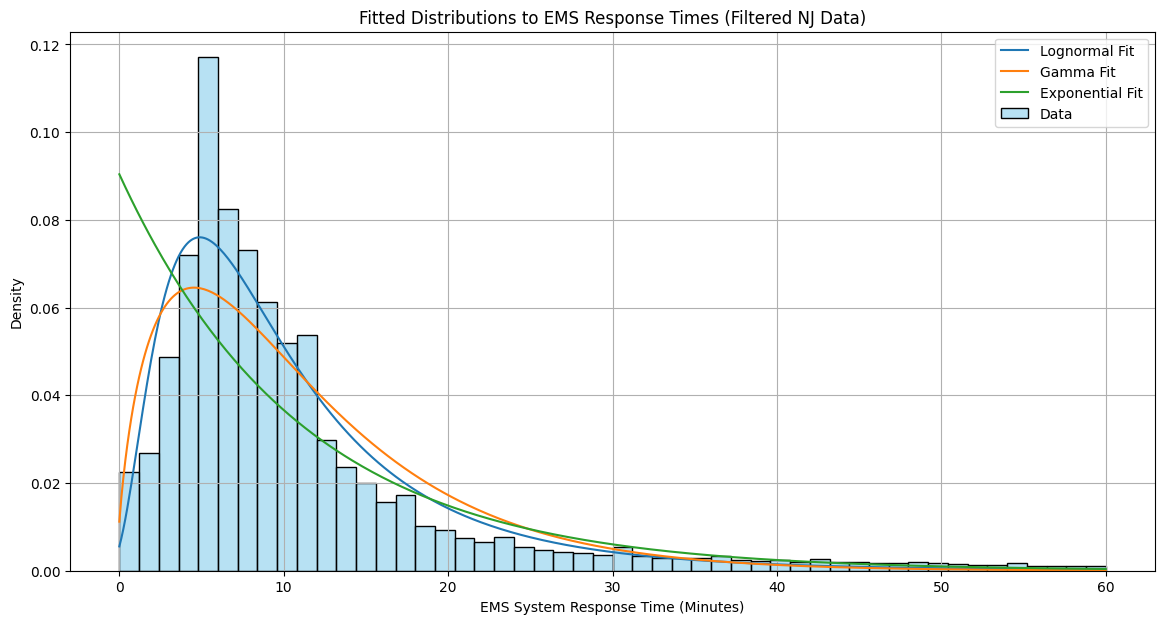


Kolmogorov-Smirnov Test Results:
Lognormal: D = 0.0579, p-value = 0.0000
Gamma: D = 0.0942, p-value = 0.0000
Exponential: D = 0.1689, p-value = 0.0000

AIC Results:
Lognormal: AIC = 37031227.93
Gamma: AIC = 37474576.67
Exponential: AIC = 38160330.62


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

response_times = filtered['EMSSystemResponseTimeMin'].dropna()
response_times = response_times[(response_times > 0) & (response_times < 60)]  # Optional cutoff

# === Step 2: Define x range and distributions ===
x = np.linspace(response_times.min(), response_times.max(), 500)
distributions = {
    "Lognormal": stats.lognorm,
    "Gamma": stats.gamma,
    "Exponential": stats.expon
}

ks_results = {}
aic_results = {}

# === Step 3: Plot ===
plt.figure(figsize=(14, 7))
sns.histplot(response_times, bins=50, stat='density', color='skyblue', label='Data', alpha=0.6)

for name, dist in distributions.items():
    try:
        params = dist.fit(response_times)
        pdf = dist.pdf(x, *params)
        plt.plot(x, pdf, label=f"{name} Fit")

        # Kolmogorov-Smirnov Test
        D, p_value = stats.kstest(response_times, dist.name, args=params)
        ks_results[name] = (D, p_value)

        # AIC Calculation
        loglik = np.sum(dist.logpdf(response_times, *params))
        k = len(params)
        aic = 2 * k - 2 * loglik
        aic_results[name] = aic

    except Exception as e:
        print(f"{name} fitting failed: {e}")

plt.xlabel('EMS System Response Time (Minutes)')
plt.ylabel('Density')
plt.title('Fitted Distributions to EMS Response Times (Filtered NJ Data)')
plt.legend()
plt.grid(True)
plt.show()

# === Step 4: Print Results ===
print("\nKolmogorov-Smirnov Test Results:")
for name, (D, p) in ks_results.items():
    print(f"{name}: D = {D:.4f}, p-value = {p:.4f}")

print("\nAIC Results:")
for name, aic in aic_results.items():
    print(f"{name}: AIC = {aic:.2f}")

In [129]:
import pandas as pd

# === Load EMS 2023 data ===
ems_file = "/Users/mosesnjuguna/Downloads/nj_2023.csv"
ems_df = pd.read_csv(ems_file)

# === Load Urbanicity Classification ===
urbanicity_file = "/Users/mosesnjuguna/Downloads/NJ_County_UIC_Urbanicity.csv"
urbanicity_df = pd.read_csv(urbanicity_file)

# === Remove ' County' from County_Name to match EMS data ===
urbanicity_df['County_Name'] = urbanicity_df['County_Name'].str.replace(' County', '')

# === Merge on County Name ===
merged_df = ems_df.merge(urbanicity_df, left_on='County', right_on='County_Name', how='left')

# === Drop extra column ===
merged_df = merged_df.drop(columns=['County_Name'])

# === Save merged file ===
merged_df.to_csv('/Users/mosesnjuguna/Downloads/nj_2023_with_urbanicity.csv', index=False)

# === Preview ===
merged_df


,County,90th Percentile Response Time,Total Calls,UIC_2013,Urbanicity
0,Atlantic,0:11:59,34302,2,Urban
1,Bergen,0:14:55,49853,1,Urban
2,Burlington,0:15:00,21665,1,Urban
3,Camden,0:11:59,31909,1,Urban
4,Cape May,0:12:00,9004,2,Urban
5,Cumberland,0:13:37,14198,2,Urban
6,Essex,0:13:27,130590,1,Urban
7,Gloucester,0:14:01,12171,1,Urban
8,Hudson,0:12:01,43801,1,Urban
9,Hunterdon,0:18:00,8042,1,Urban


In [130]:
# === Load Population Data from UIC file ===
uic_file = "/Users/mosesnjuguna/Downloads/UrbanInfluenceCodes2013.xls"
uic_df = pd.read_excel(uic_file)

# === Filter for NJ counties ===
uic_df = uic_df[uic_df['State'] == 'NJ']

# === Clean County_Name ===
uic_df['County_Name'] = uic_df['County_Name'].str.replace(' County', '')

# === Aggregate population at County Level ===
county_population = uic_df.groupby('County_Name')['Population_2010'].sum().reset_index()

# === Merge with merged_df ===
merged_df = merged_df.merge(county_population, left_on='County', right_on='County_Name', how='left')
merged_df = merged_df.drop(columns=['County_Name'])

# === Calculate Calls per 1000 People ===
merged_df['Calls_per_1000'] = merged_df['Total Calls'] / merged_df['Population_2010'] * 1000

# === Save for future use ===
merged_df.to_csv('/Users/mosesnjuguna/Downloads/nj_2023_with_urbanicity_population.csv', index=False)


In [131]:
merged_df

,County,90th Percentile Response Time,Total Calls,UIC_2013,Urbanicity,Population_2010,Calls_per_1000
0,Atlantic,0:11:59,34302,2,Urban,274549,124.939446
1,Bergen,0:14:55,49853,1,Urban,905116,55.079128
2,Burlington,0:15:00,21665,1,Urban,448734,48.280273
3,Camden,0:11:59,31909,1,Urban,513657,62.121221
4,Cape May,0:12:00,9004,2,Urban,97265,92.571840
5,Cumberland,0:13:37,14198,2,Urban,156898,90.491912
6,Essex,0:13:27,130590,1,Urban,783969,166.575464
7,Gloucester,0:14:01,12171,1,Urban,288288,42.218198
8,Hudson,0:12:01,43801,1,Urban,634266,69.057777
9,Hunterdon,0:18:00,8042,1,Urban,128349,62.657286


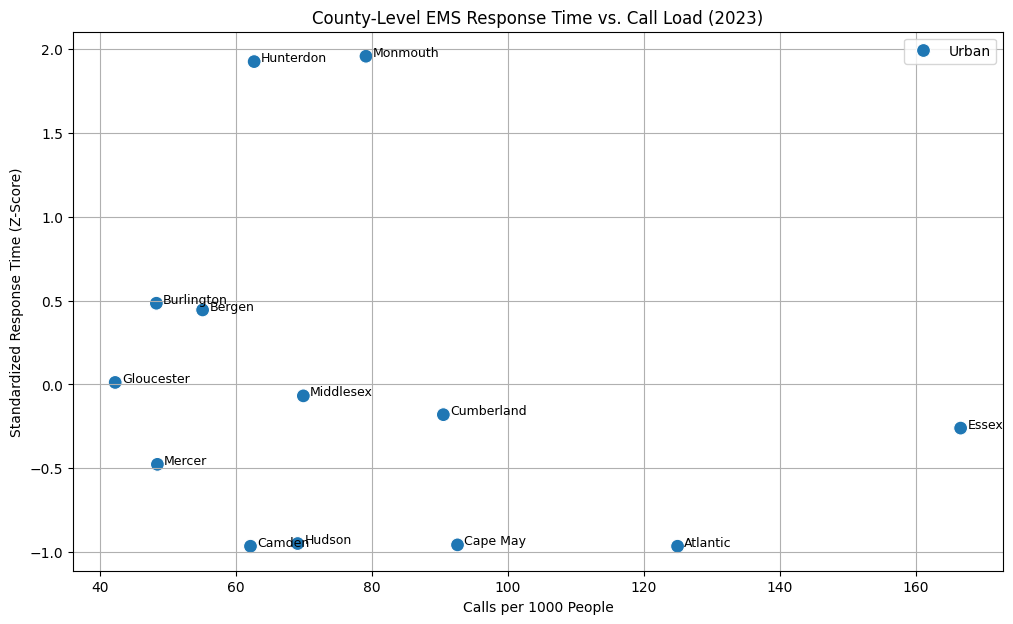


Counties with High Response Time (Adjusted for Population):
        County  ResponseTimeMin  Calls_per_1000  ResponseTime_z
12    Monmouth        18.066667       79.107840        1.958822
9    Hunterdon        18.000000       62.657286        1.926771
2   Burlington        15.000000       48.280273        0.484466
1       Bergen        14.916667       55.079128        0.444402
7   Gloucester        14.016667       42.218198        0.011711

Counties with Low Response Time (Adjusted for Population):
      County  ResponseTimeMin  Calls_per_1000  ResponseTime_z
0   Atlantic        11.983333      124.939446       -0.965851
3     Camden        11.983333       62.121221       -0.965851
4   Cape May        12.000000       92.571840       -0.957838
8     Hudson        12.016667       69.057777       -0.949826
10    Mercer        13.000000       48.429387       -0.477070


In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Convert Response Time to Minutes ---
def time_to_minutes(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m + s / 60

merged_df['ResponseTimeMin'] = merged_df['90th Percentile Response Time'].apply(time_to_minutes)

# --- Step 2: Standardize response time ---
mean_rt = merged_df['ResponseTimeMin'].mean()
std_rt = merged_df['ResponseTimeMin'].std()
merged_df['ResponseTime_z'] = (merged_df['ResponseTimeMin'] - mean_rt) / std_rt

# --- Step 3: Plot standardized response time vs. Calls per 1000 ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='Calls_per_1000',
    y='ResponseTime_z',
    hue='Urbanicity',
    data=merged_df,
    s=100
)

# Add labels
for i, row in merged_df.iterrows():
    plt.text(row['Calls_per_1000'] + 1, row['ResponseTime_z'], row['County'], fontsize=9)

plt.xlabel('Calls per 1000 People')
plt.ylabel('Standardized Response Time (Z-Score)')
plt.title('County-Level EMS Response Time vs. Call Load (2023)')
plt.grid(True)
plt.legend()
plt.show()

# --- Step 4 (Optional): Print counties with highest & lowest z-scores ---
print("\nCounties with High Response Time (Adjusted for Population):")
print(merged_df.sort_values('ResponseTime_z', ascending=False)[['County', 'ResponseTimeMin', 'Calls_per_1000', 'ResponseTime_z']].head(5))

print("\nCounties with Low Response Time (Adjusted for Population):")
print(merged_df.sort_values('ResponseTime_z', ascending=True)[['County', 'ResponseTimeMin', 'Calls_per_1000', 'ResponseTime_z']].head(5))


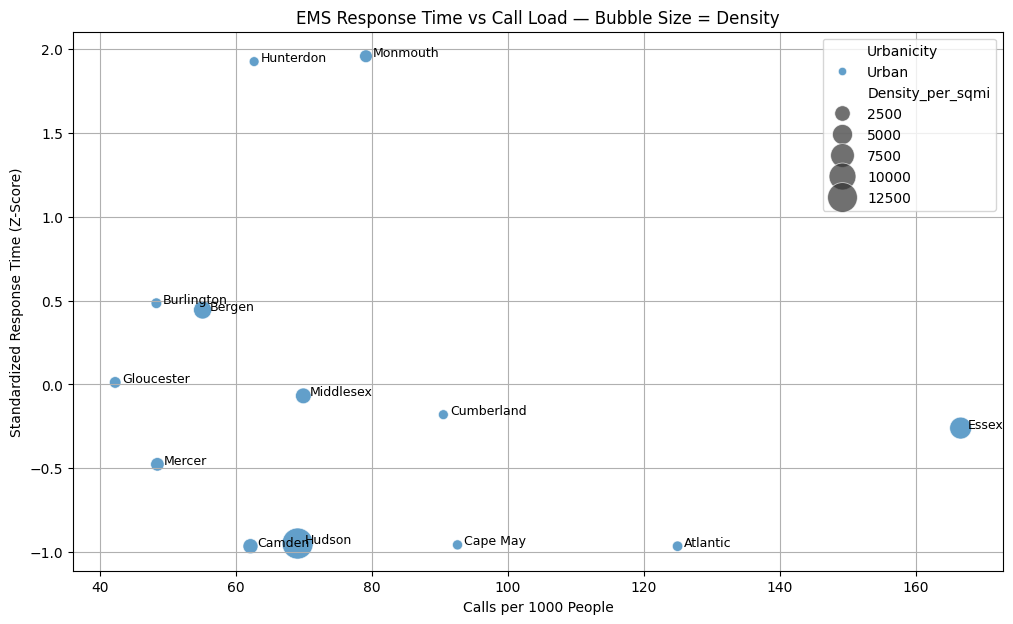

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# === Step 1: Add Land Area ===
land_area_data = {
    'Atlantic': 555.70,
    'Bergen': 233.01,
    'Burlington': 798.58,
    'Camden': 221.26,
    'Cape May': 251.43,
    'Cumberland': 483.70,
    'Essex': 126.21,
    'Gloucester': 322.01,
    'Hudson': 46.19,
    'Hunterdon': 427.82,
    'Mercer': 224.56,
    'Middlesex': 308.91,
    'Monmouth': 468.79
}

merged_df['LandArea_sqmi'] = merged_df['County'].map(land_area_data)

# === Step 2: Calculate Density ===
merged_df['Density_per_sqmi'] = merged_df['Population_2010'] / merged_df['LandArea_sqmi']

plt.figure(figsize=(12, 7))
sns.scatterplot(
    x='Calls_per_1000',
    y='ResponseTime_z',
    size='Density_per_sqmi',
    hue='Urbanicity',
    sizes=(50, 500),
    data=merged_df,
    alpha=0.7
)

# Add labels
for i, row in merged_df.iterrows():
    plt.text(row['Calls_per_1000'] + 1, row['ResponseTime_z'], row['County'], fontsize=9)

plt.xlabel('Calls per 1000 People')
plt.ylabel('Standardized Response Time (Z-Score)')
plt.title('EMS Response Time vs Call Load — Bubble Size = Density')
plt.grid(True)
plt.legend()
plt.show()



                            OLS Regression Results                            
Dep. Variable:         ResponseTime_z   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                    0.7407
Date:                Tue, 08 Apr 2025   Prob (F-statistic):              0.501
Time:                        00:18:47   Log-Likelihood:                -17.028
No. Observations:                  13   AIC:                             40.06
Df Residuals:                      10   BIC:                             41.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6345      0.726  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


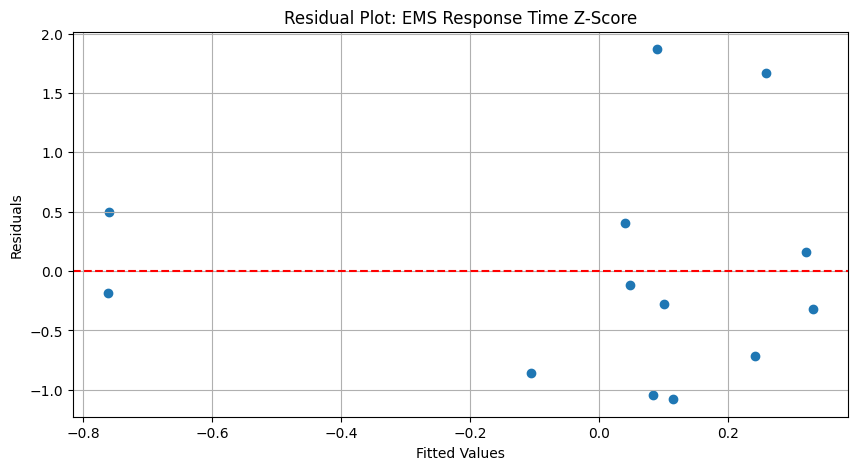

In [134]:
import statsmodels.api as sm

# === Step 1: Prepare data ===
X = merged_df[['Calls_per_1000', 'Density_per_sqmi']]
X = sm.add_constant(X)  # Adds intercept
y = merged_df['ResponseTime_z']

# === Step 2: Fit OLS model ===
model = sm.OLS(y, X).fit()

# === Step 3: Print results ===
print(model.summary())

# === Optional: Plot Residuals ===
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot: EMS Response Time Z-Score')
plt.grid(True)
plt.show()


        County  ResponseTimeMin  Simulated_90th_Log  Deviation_Log  \
0     Atlantic        11.983333           21.898746      -9.915412   
1       Bergen        14.916667           22.045718      -7.129051   
2   Burlington        15.000000           21.961263      -6.961263   
3       Camden        11.983333           21.854849      -9.871516   
4     Cape May        12.000000           21.617395      -9.617395   
5   Cumberland        13.616667           21.877642      -8.260976   
6        Essex        13.450000           21.842512      -8.392512   
7   Gloucester        14.016667           21.533381      -7.516714   
8       Hudson        12.016667           21.954455      -9.937788   
9    Hunterdon        18.000000           21.672839      -3.672839   
10      Mercer        13.000000           22.088549      -9.088549   
11   Middlesex        13.850000           21.870936      -8.020936   
12    Monmouth        18.066667           21.870153      -3.803487   

    Simulated_90th_

In [69]:
merged_df

,County,90th Percentile Response Time,Total Calls,UIC_2013,Urbanicity,Population_2010,Calls_per_1000,ResponseTimeMin,ResponseTime_z,LandArea_sqmi,Density_per_sqmi,Simulated_90th_Log,Deviation_Log,Simulated_90th_Gamma,Deviation_Gamma,Simulated_90th_Exp,Deviation_Exp
0,Atlantic,0:11:59,34302,2,Urban,274549,124.939446,11.983333,-0.965851,555.70,494.059744,21.898746,-9.915412,22.384777,-10.401444,25.740308,-13.756974
1,Bergen,0:14:55,49853,1,Urban,905116,55.079128,14.916667,0.444402,233.01,3884.451311,22.045718,-7.129051,22.536961,-7.620294,25.530965,-10.614298
2,Burlington,0:15:00,21665,1,Urban,448734,48.280273,15.000000,0.484466,798.58,561.914899,21.961263,-6.961263,22.737169,-7.737169,25.510691,-10.510691
3,Camden,0:11:59,31909,1,Urban,513657,62.121221,11.983333,-0.965851,221.26,2321.508632,21.854849,-9.871516,22.553444,-10.570111,25.538705,-13.555372
4,Cape May,0:12:00,9004,2,Urban,97265,92.571840,12.000000,-0.957838,251.43,386.847234,21.617395,-9.617395,22.065302,-10.065302,25.366432,-13.366432
5,Cumberland,0:13:37,14198,2,Urban,156898,90.491912,13.616667,-0.180596,483.70,324.370478,21.877642,-8.260976,23.119501,-9.502834,25.391367,-11.774700
6,Essex,0:13:27,130590,1,Urban,783969,166.575464,13.450000,-0.260724,126.21,6211.623485,21.842512,-8.392512,22.470932,-9.020932,25.478924,-12.028924
7,Gloucester,0:14:01,12171,1,Urban,288288,42.218198,14.016667,0.011711,322.01,895.276544,21.533381,-7.516714,22.348841,-8.332174,24.903068,-10.886401
8,Hudson,0:12:01,43801,1,Urban,634266,69.057777,12.016667,-0.949826,46.19,13731.673522,21.954455,-9.937788,22.592533,-10.575867,25.685511,-13.668844
9,Hunterdon,0:18:00,8042,1,Urban,128349,62.657286,18.000000,1.926771,427.82,300.007012,21.672839,-3.672839,22.314974,-4.314974,26.097896,-8.097896


In [135]:
import numpy as np
from scipy.stats import norm

# === Step 1: Borrow sigma from NEMSIS ===
shape, loc, scale = stats.lognorm.fit(response_times)
sigma = shape  # In scipy's lognorm, shape = sigma

# === Step 2: Compute μ for each county using their 90th percentile response time ===
z90 = norm.ppf(0.9)

# Take log of response time (in minutes)
merged_df['mu'] = np.log(merged_df['ResponseTimeMin']) - sigma * z90

# === Step 3: Compute mean response time (analytical mean of lognormal) ===
merged_df['Estimated_Mean_Response'] = np.exp(merged_df['mu'] + (sigma**2) / 2)


In [136]:
merged_df

,County,90th Percentile Response Time,Total Calls,UIC_2013,Urbanicity,Population_2010,Calls_per_1000,ResponseTimeMin,ResponseTime_z,LandArea_sqmi,Density_per_sqmi,mu,Estimated_Mean_Response
0,Atlantic,0:11:59,34302,2,Urban,274549,124.939446,11.983333,-0.965851,555.70,494.059744,1.621539,6.345447
1,Bergen,0:14:55,49853,1,Urban,905116,55.079128,14.916667,0.444402,233.01,3884.451311,1.840501,7.898714
2,Burlington,0:15:00,21665,1,Urban,448734,48.280273,15.000000,0.484466,798.58,561.914899,1.846072,7.942841
3,Camden,0:11:59,31909,1,Urban,513657,62.121221,11.983333,-0.965851,221.26,2321.508632,1.621539,6.345447
4,Cape May,0:12:00,9004,2,Urban,97265,92.571840,12.000000,-0.957838,251.43,386.847234,1.622929,6.354273
5,Cumberland,0:13:37,14198,2,Urban,156898,90.491912,13.616667,-0.180596,483.70,324.370478,1.749317,7.210334
6,Essex,0:13:27,130590,1,Urban,783969,166.575464,13.450000,-0.260724,126.21,6211.623485,1.737001,7.122081
7,Gloucester,0:14:01,12171,1,Urban,288288,42.218198,14.016667,0.011711,322.01,895.276544,1.778269,7.422143
8,Hudson,0:12:01,43801,1,Urban,634266,69.057777,12.016667,-0.949826,46.19,13731.673522,1.624317,6.363098
9,Hunterdon,0:18:00,8042,1,Urban,128349,62.657286,18.000000,1.926771,427.82,300.007012,2.028394,9.531409


/var/folders/48/fhhfjkp10pzbb1jjrdykv2040000gn/T/ipykernel_32715/1739746188.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["service_time"] = filtered["EMSSceneToPatientTimeMin"] + filtered["EMSTransportTimeMin"]


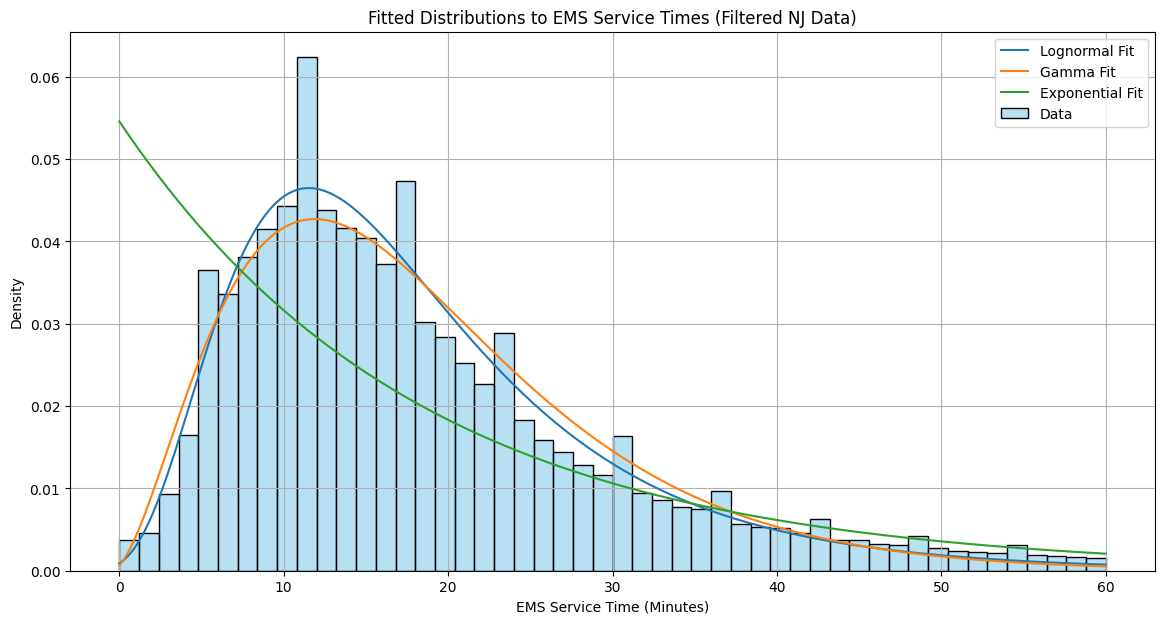


Kolmogorov-Smirnov Test Results:
Lognormal: D = 0.0184, p-value = 0.0000
Gamma: D = 0.0361, p-value = 0.0000
Exponential: D = 0.2128, p-value = 0.0000

AIC Results:
Lognormal: AIC = 29413715.53
Gamma: AIC = 29445564.17
Exponential: AIC = 31138785.84


In [141]:
filtered["service_time"] = filtered["EMSSceneToPatientTimeMin"] + filtered["EMSTransportTimeMin"]
service_times = filtered['service_time'].dropna()
service_times = service_times[(service_times > 0) & (service_times < 60)]  # Optional cutoff

# === Step 2: Define x range and distributions ===
x = np.linspace(service_times.min(), service_times.max(), 500)
distributions = {
    "Lognormal": stats.lognorm,
    "Gamma": stats.gamma,
    "Exponential": stats.expon
}

ks_results = {}
aic_results = {}

# === Step 3: Plot ===
plt.figure(figsize=(14, 7))
sns.histplot(service_times, bins=50, stat='density', color='skyblue', label='Data', alpha=0.6)

for name, dist in distributions.items():
    try:
        params = dist.fit(service_times)
        pdf = dist.pdf(x, *params)
        plt.plot(x, pdf, label=f"{name} Fit")

        # Kolmogorov-Smirnov Test
        D, p_value = stats.kstest(service_times, dist.name, args=params)
        ks_results[name] = (D, p_value)

        # AIC Calculation
        loglik = np.sum(dist.logpdf(service_times, *params))
        k = len(params)
        aic = 2 * k - 2 * loglik
        aic_results[name] = aic

    except Exception as e:
        print(f"{name} fitting failed: {e}")

plt.xlabel('EMS Service Time (Minutes)')
plt.ylabel('Density')
plt.title('Fitted Distributions to EMS Service Times (Filtered NJ Data)')
plt.legend()
plt.grid(True)
plt.show()

# === Step 4: Print Results ===
print("\nKolmogorov-Smirnov Test Results:")
for name, (D, p) in ks_results.items():
    print(f"{name}: D = {D:.4f}, p-value = {p:.4f}")

print("\nAIC Results:")
for name, aic in aic_results.items():
    print(f"{name}: AIC = {aic:.2f}")

In [142]:
filtered["EMSSceneTimeMin"].mean()

21.243877093691225

In [143]:
shape, loc, scale = stats.gamma.fit(service_times, floc=0)
mean_service_time = shape * scale
print(f"Gamma parameters: shape={shape}, loc={loc}, scale={scale}")
print(f"Mean service time = {mean_service_time:.2f} minutes")


Gamma parameters: shape=2.6621155840011492, loc=0, scale=6.887452099314515
Mean service time = 18.34 minutes


In [144]:
variance_service_time = shape * (scale ** 2)
Cs_squared = variance_service_time / (mean_service_time ** 2)


In [145]:
minutes_per_year = 365 * 24 * 60
mean_service_rate = 1/ mean_service_time
merged_df["arrival_rate"] = merged_df["Total Calls"]/minutes_per_year
merged_df["staffing"] = np.ceil(
    (merged_df["arrival_rate"] * mean_service_time) +
    ((Cs_squared + 1) / 2 * (mean_service_time / merged_df["Estimated_Mean_Response"]))
)






In [146]:
merged_df

,County,90th Percentile Response Time,Total Calls,UIC_2013,Urbanicity,Population_2010,Calls_per_1000,ResponseTimeMin,ResponseTime_z,LandArea_sqmi,Density_per_sqmi,mu,Estimated_Mean_Response,arrival_rate,staffing
0,Atlantic,0:11:59,34302,2,Urban,274549,124.939446,11.983333,-0.965851,555.70,494.059744,1.621539,6.345447,0.065263,4.0
1,Bergen,0:14:55,49853,1,Urban,905116,55.079128,14.916667,0.444402,233.01,3884.451311,1.840501,7.898714,0.094850,4.0
2,Burlington,0:15:00,21665,1,Urban,448734,48.280273,15.000000,0.484466,798.58,561.914899,1.846072,7.942841,0.041220,3.0
3,Camden,0:11:59,31909,1,Urban,513657,62.121221,11.983333,-0.965851,221.26,2321.508632,1.621539,6.345447,0.060710,4.0
4,Cape May,0:12:00,9004,2,Urban,97265,92.571840,12.000000,-0.957838,251.43,386.847234,1.622929,6.354273,0.017131,3.0
5,Cumberland,0:13:37,14198,2,Urban,156898,90.491912,13.616667,-0.180596,483.70,324.370478,1.749317,7.210334,0.027013,3.0
6,Essex,0:13:27,130590,1,Urban,783969,166.575464,13.450000,-0.260724,126.21,6211.623485,1.737001,7.122081,0.248459,7.0
7,Gloucester,0:14:01,12171,1,Urban,288288,42.218198,14.016667,0.011711,322.01,895.276544,1.778269,7.422143,0.023156,3.0
8,Hudson,0:12:01,43801,1,Urban,634266,69.057777,12.016667,-0.949826,46.19,13731.673522,1.624317,6.363098,0.083335,4.0
9,Hunterdon,0:18:00,8042,1,Urban,128349,62.657286,18.000000,1.926771,427.82,300.007012,2.028394,9.531409,0.015301,2.0


/var/folders/48/fhhfjkp10pzbb1jjrdykv2040000gn/T/ipykernel_32715/1391600167.py:118: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(counties))


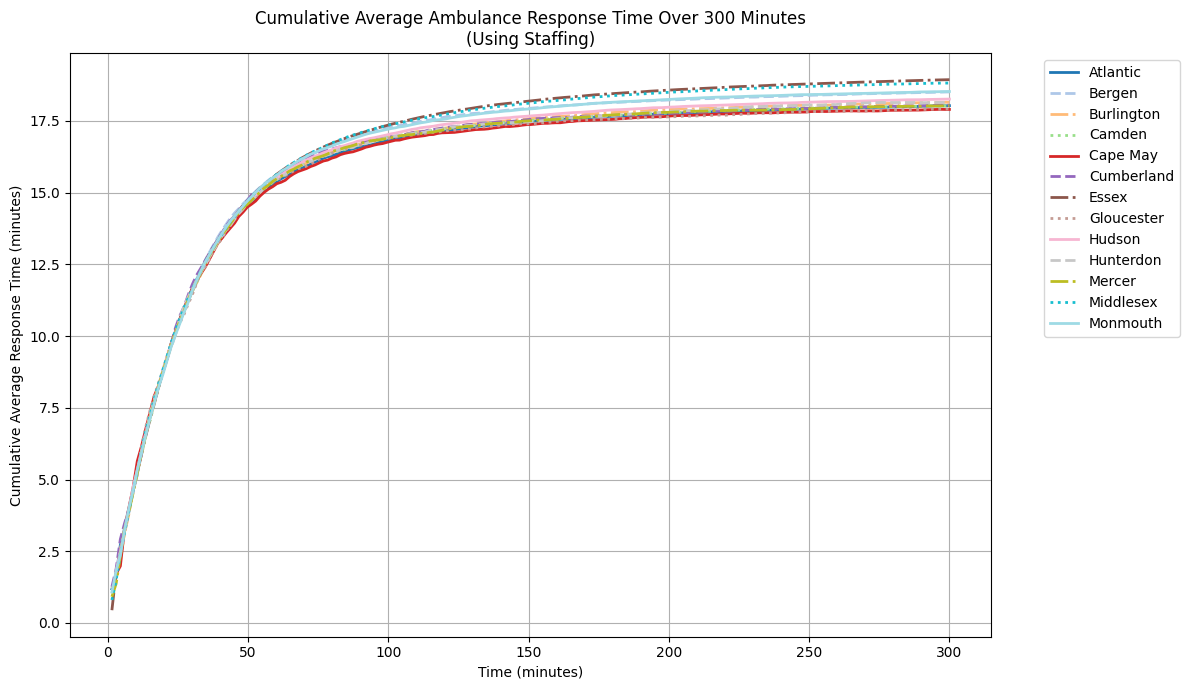

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import ttest_rel  # For later statistical testing if needed



# --- Assume merged_df is already defined with columns:
# 'County', 'arrival_rate', 'staffing', etc.

# --------------------------
# Simulation Settings
# --------------------------
shape, loc, scale = stats.gamma.fit(service_times, floc=0)
time_end = 300              # Simulation window in minutes.
num_simulations = 10000     # Number of simulation replications.
time_grid = np.linspace(0, time_end, 200)  # Time points for cumulative average.

# --------------------------
# Original Simulation Function (for cumulative plot)
# --------------------------
def run_simulation(sim_time, num_fixtures, arrival_rate):
    """
    Run one simulation replication for sim_time minutes.
    Returns an array of [finish_time, delay] for each completed call.
    """
    # Initialize ambulances: each starts as available (t_f = infinity means idle)
    ambulances = [{"t_f": np.inf, "busy": False} for _ in range(num_fixtures)]
    queue = []
    s = 0.0
    delay_data = []
    
    # Time of first call arrival.
    t_A = np.random.exponential(1 / arrival_rate)
    
    while s < sim_time:
        # Find the next time any ambulance will finish service.
        next_service_time = min(a["t_f"] for a in ambulances)
        s = min(t_A, next_service_time)
        
        if t_A <= next_service_time:
            if s < sim_time:
                # If an ambulance is available, dispatch immediately.
                available_amb = next((a for a in ambulances if not a["busy"]), None)
                if available_amb is not None:
                    available_amb["busy"] = True
                    travel_time = np.random.gamma(shape, scale)
                    available_amb["t_f"] = s + travel_time
                    delay_data.append((available_amb["t_f"], travel_time))
                else:
                    # No ambulance available; add the call to the queue.
                    queue.append(s)
                # Schedule the next call arrival.
                t_A = s + np.random.exponential(1 / arrival_rate)
            else:
                t_A = np.inf
        else:
            # A service completion event.
            completed_amb = next(a for a in ambulances if a["t_f"] == next_service_time)
            completed_amb["busy"] = False
            completed_amb["t_f"] = np.inf
            if queue:
                # Serve the waiting call.
                call_arrival = queue.pop(0)
                waiting_time = s - call_arrival
                travel_time = np.random.gamma(shape, scale)
                total_delay = waiting_time + travel_time
                completed_amb["busy"] = True
                completed_amb["t_f"] = s + travel_time
                delay_data.append((completed_amb["t_f"], total_delay))
    
    if len(delay_data) == 0:
        return np.empty((0, 2))
    else:
        return np.array(delay_data)

# --------------------------
# Cumulative Average Plot for Current Staffing
# --------------------------
county_results = {}
simulated_avg_delay = {}

for idx, row in merged_df.iterrows():
    county = row['County']
    arrival_rate = row['arrival_rate']
    # Use the original staffing number.
    staffing = int(row['staffing'])
    
    all_delay_data = []
    # Run multiple replications.
    for _ in range(num_simulations):
        data = run_simulation(time_end, staffing, arrival_rate)
        all_delay_data.append(data)
    all_delay_data = np.concatenate(all_delay_data, axis=0)
    
    times = all_delay_data[:, 0]
    total_delays = all_delay_data[:, 1]
    
    # Compute cumulative average delay over time.
    avg_response = []
    for t in time_grid:
        mask = (times <= t)
        if np.any(mask):
            avg_response.append(np.mean(total_delays[mask]))
        else:
            avg_response.append(np.nan)
    
    county_results[county] = (time_grid, avg_response)
    # Final cumulative average delay at simulation end.
    simulated_avg_delay[county] = avg_response[-1]

# Plot the cumulative average delay curves.
plt.figure(figsize=(12, 7))
counties = list(county_results.keys())
norm = mcolors.Normalize(vmin=0, vmax=len(counties) - 1)
cmap = cm.get_cmap('tab20', len(counties))
linestyles = ['-', '--', '-.', ':']

for i, county in enumerate(counties):
    x, y = county_results[county]
    color = cmap(i)
    ls = linestyles[i % len(linestyles)]
    plt.plot(x, y, label=county, color=color, linewidth=2, linestyle=ls)

plt.title("Cumulative Average Ambulance Response Time Over 300 Minutes\n(Using Staffing)")
plt.xlabel("Time (minutes)")
plt.ylabel("Cumulative Average Response Time (minutes)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# New Simulation Function for Replication-Level Final Delay (for statistical testing)
# --------------------------
def run_simulation_final(sim_time, num_fixtures, arrival_rate):
    """
    Run one simulation replication for sim_time minutes.
    Returns the final average delay (waiting + travel) for all completed calls.
    """
    ambulances = [{"t_f": np.inf, "busy": False} for _ in range(num_fixtures)]
    queue = []
    s = 0.0
    delay_list = []  # To record delay for each completed call.
    
    t_A = np.random.exponential(1 / arrival_rate)
    
    while s < sim_time:
        next_service_time = min(a["t_f"] for a in ambulances)
        s = min(t_A, next_service_time)
        
        if t_A <= next_service_time:
            if s < sim_time:
                available_amb = next((a for a in ambulances if not a["busy"]), None)
                if available_amb is not None:
                    available_amb["busy"] = True
                    travel_time = np.random.gamma(shape, scale)
                    available_amb["t_f"] = s + travel_time
                    delay_list.append(travel_time)
                else:
                    queue.append(s)
                t_A = s + np.random.exponential(1 / arrival_rate)
            else:
                t_A = np.inf
        else:
            completed_amb = next(a for a in ambulances if a["t_f"] == next_service_time)
            completed_amb["busy"] = False
            completed_amb["t_f"] = np.inf
            if queue:
                call_arrival = queue.pop(0)
                waiting_time = s - call_arrival
                travel_time = np.random.gamma(shape, scale)
                total_delay = waiting_time + travel_time
                completed_amb["busy"] = True
                completed_amb["t_f"] = s + travel_time
                delay_list.append(total_delay)
    
    if len(delay_list) == 0:
        return np.nan
    else:
        return np.mean(delay_list)

# Now you can use run_simulation_final to collect replication-level final delay values
# for statistical testing, if desired.


In [148]:
import pandas as pd
import numpy as np

# Assume merged_df is already loaded with columns:
# 'County', 'Estimated_Mean_Response', 'arrival_rate', 'mu', and 'staffing'

# --------------------------
# Step 1 — Compute the Offset for Each County
# --------------------------
# offset = arrival_rate / mu
merged_df['offset'] = merged_df['arrival_rate'] / mean_service_rate

# --------------------------
# Step 2 — Identify the Baseline County
# --------------------------
# We choose the county with the lowest Estimated_Mean_Response as the baseline.
baseline_idx = merged_df['Estimated_Mean_Response'].idxmin()
baseline_county = merged_df.loc[baseline_idx]
baseline_name = baseline_county['County']
print("Baseline county:", baseline_name)

# --------------------------
# Step 3 — Compute Baseline Effective Capacity
# --------------------------
# Effective capacity = mu * (staffing - offset)
baseline_mu = baseline_county['mu']
baseline_staffing = baseline_county['staffing']
baseline_offset = baseline_county['offset']
E_baseline = baseline_mu * (baseline_staffing - baseline_offset)
print("Baseline effective capacity E_baseline:", E_baseline)

# --------------------------
# Step 4 — Compute Equitable Staffing for Each County
# --------------------------
# For each county i, we set:
#    mu_i*(c_i - offset_i) = E_baseline  ->  c_i = offset_i + (E_baseline / mu_i)
merged_df['equitable_staffing'] = merged_df['offset'] + (E_baseline / merged_df['mu'])

# Optional: Round up to the next integer, since staffing must be whole numbers.
merged_df['equitable_staffing'] = np.ceil(merged_df['equitable_staffing'])




Baseline county: Atlantic
Baseline effective capacity E_baseline: 4.54581948779739


In [149]:
merged_df

,County,90th Percentile Response Time,Total Calls,UIC_2013,Urbanicity,Population_2010,Calls_per_1000,ResponseTimeMin,ResponseTime_z,LandArea_sqmi,Density_per_sqmi,mu,Estimated_Mean_Response,arrival_rate,staffing,offset,equitable_staffing
0,Atlantic,0:11:59,34302,2,Urban,274549,124.939446,11.983333,-0.965851,555.70,494.059744,1.621539,6.345447,0.065263,4.0,1.196602,4.0
1,Bergen,0:14:55,49853,1,Urban,905116,55.079128,14.916667,0.444402,233.01,3884.451311,1.840501,7.898714,0.094850,4.0,1.739088,5.0
2,Burlington,0:15:00,21665,1,Urban,448734,48.280273,15.000000,0.484466,798.58,561.914899,1.846072,7.942841,0.041220,3.0,0.755769,4.0
3,Camden,0:11:59,31909,1,Urban,513657,62.121221,11.983333,-0.965851,221.26,2321.508632,1.621539,6.345447,0.060710,4.0,1.113123,4.0
4,Cape May,0:12:00,9004,2,Urban,97265,92.571840,12.000000,-0.957838,251.43,386.847234,1.622929,6.354273,0.017131,3.0,0.314098,4.0
5,Cumberland,0:13:37,14198,2,Urban,156898,90.491912,13.616667,-0.180596,483.70,324.370478,1.749317,7.210334,0.027013,3.0,0.495287,4.0
6,Essex,0:13:27,130590,1,Urban,783969,166.575464,13.450000,-0.260724,126.21,6211.623485,1.737001,7.122081,0.248459,7.0,4.555542,8.0
7,Gloucester,0:14:01,12171,1,Urban,288288,42.218198,14.016667,0.011711,322.01,895.276544,1.778269,7.422143,0.023156,3.0,0.424577,3.0
8,Hudson,0:12:01,43801,1,Urban,634266,69.057777,12.016667,-0.949826,46.19,13731.673522,1.624317,6.363098,0.083335,4.0,1.527968,5.0
9,Hunterdon,0:18:00,8042,1,Urban,128349,62.657286,18.000000,1.926771,427.82,300.007012,2.028394,9.531409,0.015301,2.0,0.280540,3.0


/var/folders/48/fhhfjkp10pzbb1jjrdykv2040000gn/T/ipykernel_32715/3248601578.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(counties))


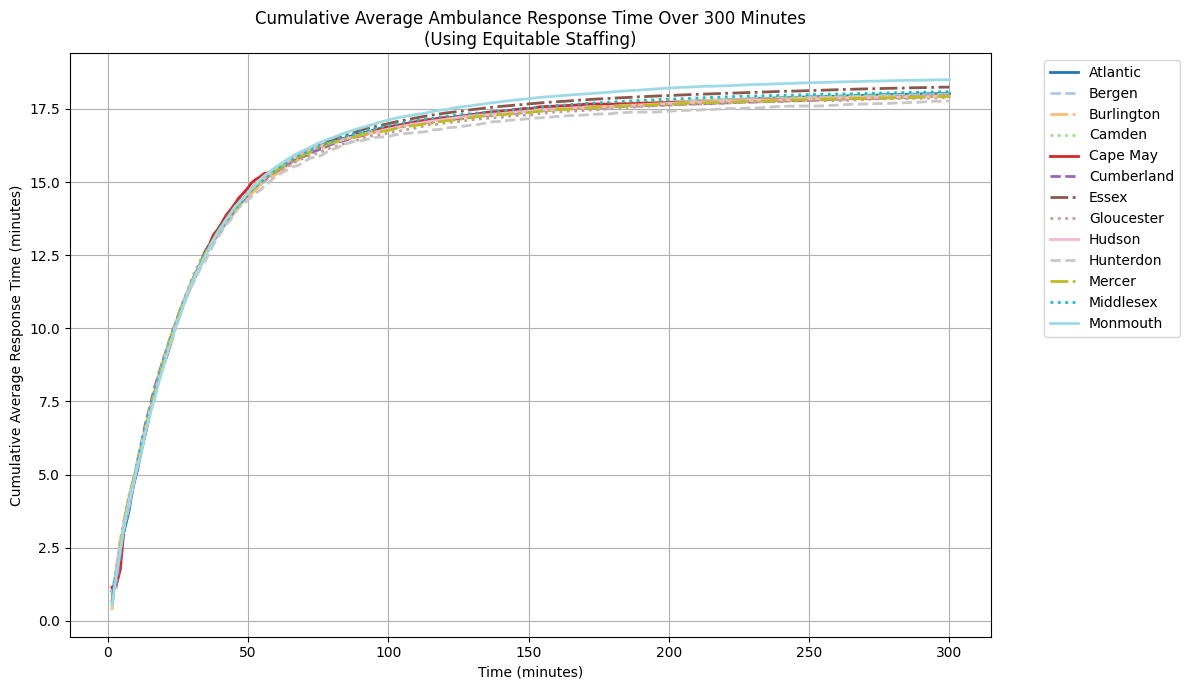

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import ttest_rel  # For later statistical testing if needed

# --- Assume merged_df is already defined with columns:
# 'County', 'Classification', 'Average_Total_Calls',
# 'Average_Response_Time_Minutes', 'service_rate', 'arrival_rate', 
# 'staffing', 'recommended_staffing', and 'equitable_staffing'
# (Your recommended staffing is computed as follows:)
# merged_df['recommended_staffing'] = np.ceil(
#    (1 / merged_df['service_rate']) * (1/8 + merged_df['arrival_rate'])
# )
# And you have computed 'equitable_staffing' via your equitable staffing formula.

# --------------------------
# Simulation Settings
# --------------------------
time_end = 300              # Simulation window in minutes.
num_simulations = 10000     # Number of simulation replications.
time_grid = np.linspace(0, time_end, 200)  # Time points for cumulative average.

# --------------------------
# Simulation Function for Cumulative Plot (Equitable Staffing)
# --------------------------
def run_simulation(sim_time, num_fixtures, arrival_rate):
    """
    Run one simulation replication for sim_time minutes.
    Returns an array of [finish_time, delay] for each completed call.
    """
    # Initialize ambulances: each starts as available (t_f = infinity means idle)
    ambulances = [{"t_f": np.inf, "busy": False} for _ in range(num_fixtures)]
    queue = []
    s = 0.0
    delay_data = []
    
    # Time of first call arrival.
    t_A = np.random.exponential(1 / arrival_rate)
    
    while s < sim_time:
        # Find the next time any ambulance will finish service.
        next_service_time = min(a["t_f"] for a in ambulances)
        s = min(t_A, next_service_time)
        
        if t_A <= next_service_time:
            if s < sim_time:
                # If an ambulance is available, dispatch immediately.
                available_amb = next((a for a in ambulances if not a["busy"]), None)
                if available_amb is not None:
                    available_amb["busy"] = True
                    travel_time = np.random.gamma(shape, scale)  # Assumes 'shape' and 'scale' are defined globally.
                    available_amb["t_f"] = s + travel_time
                    delay_data.append((available_amb["t_f"], travel_time))
                else:
                    # No ambulance available; add the call to the queue.
                    queue.append(s)
                # Schedule the next call arrival.
                t_A = s + np.random.exponential(1 / arrival_rate)
            else:
                t_A = np.inf
        else:
            # A service completion event.
            completed_amb = next(a for a in ambulances if a["t_f"] == next_service_time)
            completed_amb["busy"] = False
            completed_amb["t_f"] = np.inf
            if queue:
                # Serve the waiting call.
                call_arrival = queue.pop(0)
                waiting_time = s - call_arrival
                travel_time = np.random.gamma(shape, scale)
                total_delay = waiting_time + travel_time
                completed_amb["busy"] = True
                completed_amb["t_f"] = s + travel_time
                delay_data.append((completed_amb["t_f"], total_delay))
    
    if len(delay_data) == 0:
        return np.empty((0, 2))
    else:
        return np.array(delay_data)

# --------------------------
# Cumulative Average Plot for Equitable Staffing
# --------------------------
county_equitable_results = {}
simulated_equitable_avg_delay = {}

for idx, row in merged_df.iterrows():
    county = row['County']
    arrival_rate = row['arrival_rate']
    # Use the equitable staffing number.
    staffing = int(row['equitable_staffing'])
    
    all_delay_data = []
    # Run multiple replications.
    for _ in range(num_simulations):
        data = run_simulation(time_end, staffing, arrival_rate)
        all_delay_data.append(data)
    all_delay_data = np.concatenate(all_delay_data, axis=0)
    
    times = all_delay_data[:, 0]
    total_delays = all_delay_data[:, 1]
    
    # Compute cumulative average delay over time.
    avg_response = []
    for t in time_grid:
        mask = (times <= t)
        if np.any(mask):
            avg_response.append(np.mean(total_delays[mask]))
        else:
            avg_response.append(np.nan)
    
    county_equitable_results[county] = (time_grid, avg_response)
    # Final cumulative average delay at simulation end.
    simulated_equitable_avg_delay[county] = avg_response[-1]

# Plot the cumulative average delay curves.
plt.figure(figsize=(12, 7))
counties = list(county_equitable_results.keys())
norm = mcolors.Normalize(vmin=0, vmax=len(counties) - 1)
cmap = cm.get_cmap('tab20', len(counties))
linestyles = ['-', '--', '-.', ':']

for i, county in enumerate(counties):
    x, y = county_equitable_results[county]
    color = cmap(i)
    ls = linestyles[i % len(linestyles)]
    plt.plot(x, y, label=county, color=color, linewidth=2, linestyle=ls)

plt.title("Cumulative Average Ambulance Response Time Over 300 Minutes\n(Using Equitable Staffing)")
plt.xlabel("Time (minutes)")
plt.ylabel("Cumulative Average Response Time (minutes)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------
# Simulation Function for Replication-Level Final Delay (for statistical testing, Equitable Staffing)
# --------------------------
def run_simulation_final(sim_time, num_fixtures, arrival_rate):
    """
    Run one simulation replication for sim_time minutes.
    Returns the final average delay (waiting + travel) for all completed calls.
    """
    ambulances = [{"t_f": np.inf, "busy": False} for _ in range(num_fixtures)]
    queue = []
    s = 0.0
    delay_list = []  # To record delay for each completed call.
    
    t_A = np.random.exponential(1 / arrival_rate)
    
    while s < sim_time:
        next_service_time = min(a["t_f"] for a in ambulances)
        s = min(t_A, next_service_time)
        
        if t_A <= next_service_time:
            if s < sim_time:
                available_amb = next((a for a in ambulances if not a["busy"]), None)
                if available_amb is not None:
                    available_amb["busy"] = True
                    travel_time = np.random.gamma(shape, scale)
                    available_amb["t_f"] = s + travel_time
                    delay_list.append(travel_time)
                else:
                    queue.append(s)
                t_A = s + np.random.exponential(1 / arrival_rate)
            else:
                t_A = np.inf
        else:
            completed_amb = next(a for a in ambulances if a["t_f"] == next_service_time)
            completed_amb["busy"] = False
            completed_amb["t_f"] = np.inf
            if queue:
                call_arrival = queue.pop(0)
                waiting_time = s - call_arrival
                travel_time = np.random.gamma(shape, scale)
                total_delay = waiting_time + travel_time
                completed_amb["busy"] = True
                completed_amb["t_f"] = s + travel_time
                delay_list.append(total_delay)
    
    if len(delay_list) == 0:
        return np.nan
    else:
        return np.mean(delay_list)

# Now you can use run_simulation_final to collect replication-level final delay values
# for statistical testing, if desired.


In [151]:
# Create a DataFrame to compare the final average delays for each county.
comparison_df = pd.DataFrame({
    "County": list(simulated_avg_delay.keys()),
    "Original_Staffing_Delay": [simulated_avg_delay[county] for county in simulated_avg_delay],
    "Equitable_Staffing_Delay": [simulated_equitable_avg_delay[county] for county in simulated_equitable_avg_delay]
})

# Calculate the absolute difference (and/or percentage difference)
comparison_df["Difference"] = comparison_df["Equitable_Staffing_Delay"] - comparison_df["Original_Staffing_Delay"]
comparison_df["Pct_Difference"] = (comparison_df["Difference"] / comparison_df["Original_Staffing_Delay"]) * 100



In [152]:
comparison_df

,County,Original_Staffing_Delay,Equitable_Staffing_Delay,Difference,Pct_Difference
0,Atlantic,18.032120,18.026570,-0.005550,-0.030779
1,Bergen,18.510652,18.002193,-0.508458,-2.746842
2,Burlington,18.150875,17.959805,-0.191070,-1.052676
3,Camden,18.026373,18.017339,-0.009034,-0.050113
4,Cape May,17.901124,17.934682,0.033559,0.187467
5,Cumberland,18.049603,17.938518,-0.111084,-0.615439
6,Essex,18.938471,18.245152,-0.693319,-3.660903
7,Gloucester,17.918482,17.883564,-0.034918,-0.194871
8,Hudson,18.261513,17.929296,-0.332217,-1.819221
9,Hunterdon,18.144504,17.767208,-0.377296,-2.079393


In [153]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

# --- Simulation Settings (same as before) ---
time_end = 300              # Simulation window in minutes.
num_simulations = 10000     # Number of simulation replications.

# --- Assume run_simulation_final(sim_time, num_fixtures, arrival_rate) is defined ---
# It returns a single number: the final average delay (waiting + travel) for that replication.
#
# For example, run_simulation_final might look like:
# def run_simulation_final(sim_time, num_fixtures, arrival_rate):
#     # ... (simulation code) ...
#     return final_average_delay

# --------------------------
# Collect Replication-Level Final Delays for Current Staffing
# --------------------------
replication_delays_current = {}

for idx, row in merged_df.iterrows():
    county = row['County']
    arrival_rate = row['arrival_rate']
    staffing_current = int(row['staffing'])
    
    delays = []
    for _ in range(num_simulations):
        d = run_simulation_final(time_end, staffing_current, arrival_rate)
        delays.append(d)
    replication_delays_current[county] = np.array(delays)

# --------------------------
# Collect Replication-Level Final Delays for Equitable Staffing
# --------------------------
replication_delays_equitable = {}

for idx, row in merged_df.iterrows():
    county = row['County']
    arrival_rate = row['arrival_rate']
    staffing_equitable = int(row['equitable_staffing'])
    
    delays = []
    for _ in range(num_simulations):
        d = run_simulation_final(time_end, staffing_equitable, arrival_rate)
        delays.append(d)
    replication_delays_equitable[county] = np.array(delays)

# --------------------------
# Perform Paired t-Test for Each County
# --------------------------
results = []

for county in merged_df['County']:
    # Retrieve the replication-level arrays
    delays_current = replication_delays_current[county]
    delays_equitable = replication_delays_equitable[county]
    
    # Perform paired t-test (assuming pairing by replication)
    t_stat, p_val = ttest_rel(delays_current, delays_equitable)
    
    mean_current = np.nanmean(delays_current)
    mean_equitable = np.nanmean(delays_equitable)
    difference = mean_equitable - mean_current
    
    results.append({
        'County': county,
        'Current_Mean_Delay': mean_current,
        'Equitable_Mean_Delay': mean_equitable,
        'Difference': difference,
        't_stat': t_stat,
        'p_val': p_val
    })

results_df = pd.DataFrame(results)
print("Paired t-test Results Comparing Current vs. Equitable Staffing:")
print(results_df)


Paired t-test Results Comparing Current vs. Equitable Staffing:
        County  Current_Mean_Delay  Equitable_Mean_Delay  Difference  \
0     Atlantic           18.481712             18.434840   -0.046872   
1       Bergen           18.863734             18.465606   -0.398128   
2   Burlington           18.506745             18.321251   -0.185494   
3       Camden           18.444450             18.432586   -0.011864   
4     Cape May           18.256218             18.381226    0.125008   
5   Cumberland           18.350037             18.345790   -0.004247   
6        Essex           19.344861             18.710291   -0.634571   
7   Gloucester           18.308929             18.362677    0.053747   
8       Hudson           18.683237             18.379130   -0.304106   
9    Hunterdon           18.526285             18.375338   -0.150948   
10      Mercer           18.470044             18.351413   -0.118631   
11   Middlesex           19.180638             18.566789   -0.613849   


In [154]:
results_df

,County,Current_Mean_Delay,Equitable_Mean_Delay,Difference,t_stat,p_val
0,Atlantic,18.481712,18.434840,-0.046872,1.211699,2.256563e-01
1,Bergen,18.863734,18.465606,-0.398128,11.766667,9.384901e-32
2,Burlington,18.506745,18.321251,-0.185494,3.833075,1.273270e-04
3,Camden,18.444450,18.432586,-0.011864,0.302578,7.622181e-01
4,Cape May,18.256218,18.381226,0.125008,NaN,NaN
5,Cumberland,18.350037,18.345790,-0.004247,NaN,NaN
6,Essex,19.344861,18.710291,-0.634571,24.311346,6.836726e-127
7,Gloucester,18.308929,18.362677,0.053747,NaN,NaN
8,Hudson,18.683237,18.379130,-0.304106,8.737107,2.775091e-18
9,Hunterdon,18.526285,18.375338,-0.150948,NaN,NaN


In [102]:
filtered

,PcrKey,USCensusRegion,USCensusDivision,NasemsoRegion,Urbanicity,ageinyear,EMSDispatchCenterTimeSec,EMSChuteTimeMin,EMSSystemResponseTimeMin,EMSSceneResponseTimeMin,EMSSceneTimeMin,EMSSceneToPatientTimeMin,EMSTransportTimeMin,EMSTotalCallTimeMin,service_time
48319,225907144.0,Northeast,Middle Atlantic,East,Urban,NaN,NaN,0.016667,4.200000,4.183333,NaN,NaN,NaN,7.783333,NaN
48320,225907151.0,Northeast,Middle Atlantic,East,Urban,24.0,NaN,0.016667,7.083333,7.066667,3.033333,NaN,NaN,10.133333,NaN
48321,225907154.0,Northeast,Middle Atlantic,East,Urban,NaN,NaN,0.000000,7.000000,7.000000,NaN,NaN,NaN,18.000000,NaN
48322,225907155.0,Northeast,Middle Atlantic,East,Urban,54.0,NaN,0.000000,2.650000,2.650000,16.166667,NaN,2.850000,34.216667,19.016667
48323,225907220.0,Northeast,Middle Atlantic,East,Urban,58.0,65.0,0.000000,2.066667,2.066667,8.600000,NaN,3.533333,23.750000,12.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54150022,289229413.0,Northeast,Middle Atlantic,East,Urban,28.0,420.0,0.000000,10.000000,10.000000,11.000000,1.000000,NaN,21.000000,NaN
54150023,289229644.0,Northeast,Middle Atlantic,East,Urban,60.0,102.0,1.550000,10.150000,8.600000,11.833333,2.316667,18.433333,49.966667,30.266667
54150024,289230443.0,Northeast,Middle Atlantic,East,Urban,77.0,0.0,0.033333,0.050000,0.016667,2.416667,0.066667,6.416667,30.116667,8.833333
54150025,289230875.0,Northeast,Middle Atlantic,East,Urban,38.0,165.0,2.250000,5.816667,3.566667,12.833333,1.666667,20.250000,76.850000,33.083333
